In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [13]:
import xgboost as xgb

In [14]:
calendar = pd.read_csv("calendar_summary.csv")
listings = pd.read_csv("listings.csv")
listings_sum = pd.read_csv("listings_summary.csv")
neighbourhoods = pd.read_csv("neighbourhoods.csv")
reviews = pd.read_csv("reviews.csv")
reviews_summary = pd.read_csv("reviews_summary.csv")

## Información de los data sets 

In [ ]:
calendar.info()
#calendar.head()

In [ ]:
listings_sum.info()

In [ ]:
listings_sum

In [ ]:
listings.info()

# Para este set de data, es necesario realizar una serie de transformaciones ya que algunas columnas no cumplen con el formato requerido para realizar el análisis.

In [15]:
num = re.compile(r'\$')
coma = re.compile(r'\,')
listings_sum.price = listings_sum.price.apply(lambda x:float(coma.sub("", num.sub("", x))))

In [ ]:
listings_sum.info()

In [ ]:
neighbourhoods.info()
#neighbourhoods.head()

In [ ]:
reviews_summary.head()

## Busqueda de Insights dentro de la información

In [ ]:
#listings[(listings.price <= 2000) & (listings.price > 500)].price.hist()
listings.price.hist()
#listings[(listings.price <= 500)].price.hist()
#listings[(listings.price <= 100)].price.hist()
#listings[(listings.price > 500)].price.hist()


# Estos histogramas nos muestran que la mayor cantidad de lugares dentro de la información tienen un valor inferior a 500 dólares, dentro de eso valores menores a 500, la mayor cantidad son inferiores a 100 dólares, y dentro de esos 100, la mayor cantidad es de 30 a 40 dólares.

In [ ]:
listings[listings.price <= 100].plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, c="price", figsize=(10,7), cmap="jet", colorbar=True,
)

# Con este gráfico podemos darnos cuenta que la latitud y la longitud no tienen relación con el precio de los lugares

In [ ]:
listings_sum[(listings_sum.price > 500)].describe()

In [ ]:
listings_sum[(listings_sum.price > 500)].select_dtypes(exclude=['object']).corr()["price"]
#np.corrcoef(listings_sum.dropna(subset=['beds']).price, listings_sum.dropna(subset=['beds']).beds)

# Se puede observar claramente que las variables numéricas que más influencia tienen en general son square_feet, accommodates, bathrooms, bedrooms y beds. Para los valores de los lugares mayores a 500 dólares, tienden a tener importancia maximun y minimum night, al igual que latitud y longitud.

In [ ]:
listings_sum.select_dtypes(exclude=['int64', 'float64']).iloc[:,40:50]

# Vamos a recuperar City, state, property_type, room_type, bed_type

In [ ]:
#pd.get_dummies(listings_sum[["city", "state", "property_type", "room_type", "bed_type"]])

s = pd.get_dummies(listings_sum[["price", "state", "property_type", "room_type", "bed_type"]]).corr()["price"]
s[s > 0.1]

# Observamos entonces que unicamente tanto room_type, como Property_type, son variables categóricas que influyen significativamente en el precio

In [ ]:
listings_sum[(listings_sum.price > 2000)].amenities.value_counts().head(20)

# Podemos observar que las comodidaes se caracterizan principalemente por estas categorías: TV, Internet, Wi-fi, Kitchen, Essentials, Buzzer/wireless intercom, Heating, Washer, Family/kid friendly, Hangers, Laptop friendly workspace, Hair dryer, Iron, Shampoo, Smoking allowed

In [16]:
#Creamos una función para detectar caracteres
def charac(x, palabra):
    
    y = 1 if palabra in x else 0
    
    return y    

In [17]:
listings_sum["Water"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "water"))
listings_sum["SmokeD"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "smoke"))
listings_sum["BedLinens"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "linens"))
listings_sum["Elevator"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "elevator"))
listings_sum["Air"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "air"))
listings_sum["Gym"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "gym"))
listings_sum["Breakfast"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "breakfast"))
listings_sum["TV"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "tv"))
listings_sum["Wifi"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "wifi"))
listings_sum["Kitchen"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "kitchen"))
listings_sum["Internet"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "internet"))
listings_sum["Essentials"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "essentials"))
listings_sum["Buzzer"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "buzzer"))
listings_sum["Heating"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "heating"))
listings_sum["Washer"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "washer"))
listings_sum["Family"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "familyHangers"))
listings_sum["Hangers"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "hangers"))
listings_sum["Laptop"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "laptop"))
listings_sum["dryer"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "dryer"))
listings_sum["Iron"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "iron"))
listings_sum["Shampoo"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "shampoo"))
listings_sum["Smoking"] = listings_sum.amenities.apply(lambda x:charac(x.lower(), "smoking"))

In [18]:
listings_sum[["price", "TV", "SmokeD", "BedLinens", "Internet", "Wifi", "Kitchen", "Essentials", "Air", "Gym", "Water", "Breakfast", "Elevator", "Buzzer", "Heating", "Washer", "Family", "Hangers", "Laptop", "dryer", "Iron", "Shampoo", "Smoking"]][listings_sum.price <= 100].corr()["price"]

price         1.000000
TV            0.258278
SmokeD        0.111596
BedLinens     0.089386
Internet      0.041110
Wifi          0.016970
Kitchen       0.056624
Essentials    0.038223
Air           0.134492
Gym           0.022545
Water         0.135072
Breakfast    -0.003405
Elevator      0.103186
Buzzer        0.078803
Heating       0.061922
Washer       -0.002868
Family             NaN
Hangers       0.125517
Laptop        0.067190
dryer         0.133702
Iron          0.168602
Shampoo       0.128805
Smoking      -0.160311
Name: price, dtype: float64

# Observamos que claramente la mayoría de las categoría no tienen una influencia importante en general, sin embargo para aquellos lugares de mas de 500 dólares tienen importancia, SmokeD, BedLinens, Kitchen, Gym, Heating, Washer y Laptop, por ende vamos a usarlas, porque pueden ayudarnos a detectar los outliers de una manera mas precisa.

In [19]:
#Comenzamos estructurando la base con las categóricas que son room_type y property_type

BaseTot = pd.get_dummies(listings_sum[["price", "room_type", "property_type"]])
BaseTot

,price,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,...,property_type_Loft,property_type_Other,property_type_Pension (South Korea),property_type_Resort,property_type_Serviced apartment,property_type_Tiny house,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Villa
0,60.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,90.0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22547,60.0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22548,20.0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22549,85.0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
22550,99.0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#Escogemos las otras variables numéricas y creadas por nosotros

Comp = listings_sum[["square_feet", "accommodates", "bathrooms", "bedrooms", "beds", "minimum_nights", "maximum_nights", "latitude", "longitude", "SmokeD", "BedLinens", "Kitchen", "Gym", "Heating", "Washer", "Laptop"]]

In [21]:
#Ahora pegamos las dos bases

BaseTot = pd.concat([BaseTot, Comp], axis = 1)
BaseTot

,price,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,...,maximum_nights,latitude,longitude,SmokeD,BedLinens,Kitchen,Gym,Heating,Washer,Laptop
0,60.0,1,0,0,0,0,0,0,0,0,...,1125,52.534537,13.402557,1,1,1,1,1,1,1
1,17.0,0,1,0,0,1,0,0,0,0,...,40,52.548513,13.404553,0,0,1,0,1,1,1
2,90.0,1,0,0,0,1,0,0,0,0,...,1125,52.534996,13.417579,1,0,1,0,1,1,1
3,26.0,0,1,0,0,1,0,0,0,0,...,360,52.498855,13.349065,1,1,0,0,1,1,1
4,42.0,0,1,0,0,1,0,0,0,0,...,10,52.543157,13.415091,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22547,60.0,1,0,0,0,1,0,0,0,0,...,1125,52.533865,13.400731,0,0,0,0,1,0,1
22548,20.0,0,0,1,0,1,0,0,0,0,...,14,52.496211,13.341738,1,1,1,0,1,1,1
22549,85.0,1,0,0,0,0,0,0,0,0,...,30,52.531800,13.411999,0,0,1,0,1,1,0
22550,99.0,0,1,0,0,0,0,0,0,1,...,10,52.520802,13.378688,1,0,0,0,1,0,1


In [22]:
BaseTot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 53 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   price                                 22552 non-null  float64
 1   room_type_Entire home/apt             22552 non-null  uint8  
 2   room_type_Private room                22552 non-null  uint8  
 3   room_type_Shared room                 22552 non-null  uint8  
 4   property_type_Aparthotel              22552 non-null  uint8  
 5   property_type_Apartment               22552 non-null  uint8  
 6   property_type_Barn                    22552 non-null  uint8  
 7   property_type_Bed and breakfast       22552 non-null  uint8  
 8   property_type_Boat                    22552 non-null  uint8  
 9   property_type_Boutique hotel          22552 non-null  uint8  
 10  property_type_Bungalow                22552 non-null  uint8  
 11  property_type_C

In [23]:
#Rellenamos los NA, y eliminamos las columnas correspondientes.

medianb = BaseTot["bathrooms"].median() # option 3
BaseTot["bathrooms"].fillna(medianb, inplace=True)

medianbe = BaseTot["bedrooms"].median() # option 3
BaseTot["bedrooms"].fillna(medianbe, inplace=True)

medianbed = BaseTot["beds"].median() # option 3
BaseTot["beds"].fillna(medianbed, inplace=True)

BaseTot = BaseTot.drop("square_feet", axis = 1)

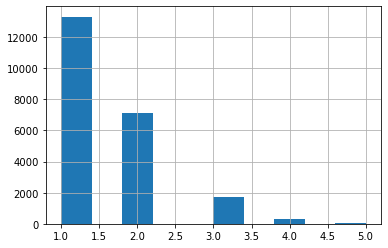

In [24]:
#Vamos a revoisar como se comporta el precio por medio de una estratificación.

BaseTot["price_cat"] = pd.cut(BaseTot["price"],
bins=[-100, 50, 100, 200, 500, np.inf],
labels=[1, 2, 3, 4, 5])

BaseTot["price_cat"].hist()

In [25]:
#Procedemos a separar la información en train y test para poder estructurar el modelo de una manera más adecuada

train_set, test_set = train_test_split(BaseTot, test_size=0.2,
random_state=42)

In [26]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(BaseTot, BaseTot["price_cat"]):
    strat_train_set = BaseTot.loc[train_index]
    strat_test_set = BaseTot.loc[test_index]

In [ ]:
strat_test_set["price_cat"].value_counts() / len(strat_test_set)

In [ ]:
test_set["price_cat"].value_counts() / len(test_set)

In [ ]:
BaseTot["price_cat"].value_counts() / len(BaseTot)

# Se puede observar claramente que la división de la información de forma estratificada es mucho más exacta que la información puramente aleatorizada

In [27]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("price_cat", axis=1, inplace=True)

In [28]:
X_test = strat_test_set.drop("price", axis = 1).values
X_train = strat_train_set.drop("price", axis = 1).values
y_test = strat_test_set["price"].values.reshape(-1, 1)
y_train = strat_train_set["price"].values.reshape(-1, 1)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

In [ ]:
Predictions = lin_reg.predict(X_test)

In [ ]:
linreg_mse = mean_squared_error(y_test, Predictions)

In [ ]:
np.sqrt(linreg_mse)

In [ ]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

In [ ]:
Predictions_tree = tree_reg.predict(X_test)

In [ ]:
tree_mse = mean_squared_error(y_test, Predictions_tree)
np.sqrt(tree_mse)

In [ ]:
scorestree = cross_val_score(tree_reg, BaseTot.drop("price", axis=1), BaseTot[["price"]],
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scorestree)
tree_rmse_scores

In [ ]:
# Una mejor evaluación se puede lograr usando K-FOL Cross validation
scoreslreg = cross_val_score(lin_reg, BaseTot.drop("price", axis=1), BaseTot[["price"]],
scoring="neg_mean_squared_error", cv=10)
linreg_rmse_scores = np.sqrt(-scoreslreg)
linreg_rmse_scores

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(linreg_rmse_scores)

# Observamos que el error cudrático medio es menor en el arbol de decisión mediante K-Fold Cross Validation, pero mayor en la validadción por train, test.

In [ ]:
#Vamos ahora con el Random Forest
forest_reg = RandomForestRegressor()

In [ ]:
forest_reg.fit(X_train, y_train)

In [ ]:
Predictions_Rf = forest_reg.predict(X_test)

In [ ]:
Rf_mse = mean_squared_error(y_test, Predictions_Rf)
Rf_mse

In [ ]:
# Claramente el Random Forest es el mejor modelo entre los 3 entrenados, ahora escogeremos el de mejores parámetros
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3,4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(BaseTot.drop("price", axis=1), BaseTot[["price"]])

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
Rf_mse = mean_squared_error(y_test, Predictions_Rf)
Rf_mse

In [29]:
#Probamos el XGBoost

booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)

In [30]:
booster.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=4,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
Predictions_xg = booster.predict(X_test)

In [32]:
Xg_mse = mean_squared_error(y_test, Predictions_xg)

In [33]:
np.sqrt(Xg_mse)

114.81338887336418